In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import random
from collections import Counter
from scipy import stats
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.manifold import TSNE
from imblearn.combine import SMOTEENN
from sklearn.model_selection import cross_val_score
from sklearn import metrics
import keras
from keras.layers.normalization import BatchNormalization
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Dropout, Input, Activation
from keras.optimizers import Adam
from keras import regularizers
from keras.wrappers.scikit_learn import KerasRegressor
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import keras.backend as K
import matplotlib.pyplot as plt
%matplotlib inline

/home/rstudio/efs/anaconda3/envs/dl/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
Using TensorFlow backend.


In [2]:
def rmse(targets, predictions):
    return np.sqrt(((predictions - targets) ** 2).mean())

def rmse_(y_true, y_pred):
    return (K.mean((((y_pred-y_true))**2)))**(1/2)

### Load Data

In [78]:
# Load oversampled X
oversampled_X_train = np.load('../Data/oversampled_X_train.npy')
# Load oversampled y
oversampled_y_train = np.load('../Data/overssampled_y_train.npy')
# load smoted_data
smoted_X_y = np.load('../Data/smoted_train_X_and_y.npy')
# load test set
norm_test_x = np.load('../Data/norm_test.npy')
dim_reduced_test_x = np.load('../Data/autoencoded_data_test.npy')
y_test = np.load('../Data/y_test.npy')

### Load Classfication model

In [4]:
mlp_classification_oversample = keras.models.load_model('../02__Classification/mlp_classification_oversample.h5')
mlp_classification_smote = keras.models.load_model('../02__Classification/mlp_classification_smote.h5')

#### Because our classfication model has a higher false positive rate, we want to select some non-buyers who are very similar to buyers, (i.e. non-spenders who were predicted of being 45%-50%(threshold) of being a buyer) and combine these them as our new traning data for regression model

In [12]:
def find_sim_buyers(data, label, model):
    non_buyers = data[label==0]
    probability = model.predict_proba(non_buyers)
    index = np.where(np.logical_and(probability>=0.45, probability<0.5))[0]
    return non_buyers[index]

### find similar buyers for oversampled data first

In [121]:
# we will add these non_buyers to buyers
sim_buyers_x = find_sim_buyers(oversampled_X_train, oversampled_y_train, mlp_classification_oversample)
sim_buyers_y = np.zeros((len(sim_buyers_x),1))

159968/160014 [============================>.] - ETA: 0s

In [123]:
# select buyers only
buyer_index = oversampled_y_train>0

oversampled_X_regression = oversampled_X_train[buyer_index]
oversampled_y_regression = oversampled_y_train[buyer_index]
oversampled_y_regression = oversampled_y_regression.reshape((oversampled_y_regression.shape[0],1))

In [124]:
oversampled_X_regression = np.concatenate((oversampled_X_regression, sim_buyers_x))
oversampled_y_regression = np.vstack((oversampled_y_regression,sim_buyers_y))

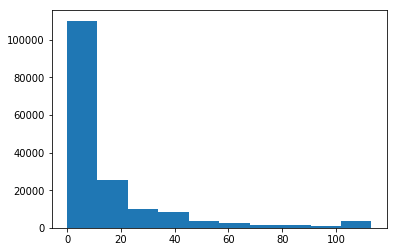

In [128]:
# see how buyers' ltv distributed
plt.hist(oversampled_y_regression);

### now lets find similar buyers for smote data

In [6]:
smote_x = smoted_X_y[:,:-1]
smote_y = smoted_X_y[:,-1]

In [14]:
sim_buyers_xsmote = find_sim_buyers(smote_x, smote_y, mlp_classification_smote)
sim_buyers_ysmote = np.zeros((len(sim_buyers_xsmote),1))

158112/160014 [============================>.] - ETA: 0s

In [15]:
# select buyers only
buyer_index2 = smote_y>0

xsmote_regression = smote_x[buyer_index2]
ysmote_regression = smote_y[buyer_index2]
ysmote_regression = ysmote_regression.reshape((ysmote_regression.shape[0],1))

In [16]:
xsmote_regression = np.concatenate((xsmote_regression, sim_buyers_xsmote))
ysmote_regression = np.vstack((ysmote_regression,sim_buyers_ysmote))

### Modeling w/ oversampled data first

In [179]:
def create_model(learn_rate=0.01, decay=0.01 ,init='normal', drop_out=0.2, loss='mse'):
    model = Sequential()
    model.add(Dense(units=240, kernel_initializer=init, input_shape=(oversampled_X_regression.shape[1],)))
    model.add(Activation(activation='relu'))
    model.add(Dropout(drop_out))
    model.add(Dense(units=120, kernel_initializer=init))
    model.add(Activation(activation='relu'))
    model.add(Dropout(drop_out))
    model.add(Dense(units=60, kernel_initializer=init))
    model.add(Activation(activation='relu'))
    model.add(Dropout(drop_out))
    model.add(Dense(1, kernel_initializer='normal'))
    model.compile(loss=loss, 
              optimizer=Adam(lr=learn_rate, decay=decay), 
              metrics=[rmse_])
    return model

model = create_model()

In [180]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_30 (Dense)             (None, 240)               77040     
_________________________________________________________________
activation_22 (Activation)   (None, 240)               0         
_________________________________________________________________
dropout_18 (Dropout)         (None, 240)               0         
_________________________________________________________________
dense_31 (Dense)             (None, 120)               28920     
_________________________________________________________________
activation_23 (Activation)   (None, 120)               0         
_________________________________________________________________
dropout_19 (Dropout)         (None, 120)               0         
_________________________________________________________________
dense_32 (Dense)             (None, 60)                7260      
__________

In [181]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                  factor=0.2, 
                  patience=5,   
                  epsilon=0.0001,  
                  min_lr=0)
modelchecker = ModelCheckpoint('mlp_model_OS.h5', save_best_only=True)

earlystopper = EarlyStopping(patience=12, mode='min')

In [182]:
batch_size = 500
epochs = 1000
history = model.fit(oversampled_X_regression, oversampled_y_regression,
                    validation_split=0.33,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    callbacks=[reduce_lr, earlystopper, modelchecker])

Train on 112247 samples, validate on 55286 samples
Epoch 1/1000
112247/112247 [==============================] - 3s - loss: 521.3481 - rmse_: 22.7732 - val_loss: 468.3660 - val_rmse_: 21.5134
Epoch 2/1000
112247/112247 [==============================] - 3s - loss: 504.4369 - rmse_: 22.4120 - val_loss: 460.2331 - val_rmse_: 21.2940
Epoch 3/1000
112247/112247 [==============================] - 3s - loss: 501.7625 - rmse_: 22.3479 - val_loss: 454.6955 - val_rmse_: 21.1173
Epoch 4/1000
112247/112247 [==============================] - 3s - loss: 499.8208 - rmse_: 22.3150 - val_loss: 455.7147 - val_rmse_: 21.1728
Epoch 5/1000
112247/112247 [==============================] - 3s - loss: 498.7808 - rmse_: 22.2838 - val_loss: 458.0826 - val_rmse_: 21.2554
Epoch 6/1000
112247/112247 [==============================] - 3s - loss: 497.2107 - rmse_: 22.2460 - val_loss: 455.2678 - val_rmse_: 21.1750
Epoch 7/1000
112247/112247 [==============================] - 3s - loss: 496.2452 - rmse_: 22.2303 - va

112247/112247 [==============================] - 3s - loss: 423.1475 - rmse_: 20.5265 - val_loss: 389.5608 - val_rmse_: 19.6320
Epoch 116/1000
112247/112247 [==============================] - 3s - loss: 423.7812 - rmse_: 20.5461 - val_loss: 389.9407 - val_rmse_: 19.6507
Epoch 117/1000
112247/112247 [==============================] - 3s - loss: 424.1762 - rmse_: 20.5455 - val_loss: 388.6254 - val_rmse_: 19.5996
Epoch 118/1000
112247/112247 [==============================] - 3s - loss: 424.5146 - rmse_: 20.5614 - val_loss: 389.5355 - val_rmse_: 19.6455
Epoch 119/1000
112247/112247 [==============================] - 3s - loss: 423.1674 - rmse_: 20.5309 - val_loss: 388.6032 - val_rmse_: 19.6167
Epoch 120/1000
112247/112247 [==============================] - 3s - loss: 421.4407 - rmse_: 20.4849 - val_loss: 388.6604 - val_rmse_: 19.6247
Epoch 121/1000
112247/112247 [==============================] - 3s - loss: 422.0492 - rmse_: 20.4969 - val_loss: 388.0381 - val_rmse_: 19.6021
Epoch 122/1000

112247/112247 [==============================] - 3s - loss: 386.5744 - rmse_: 19.6175 - val_loss: 355.2381 - val_rmse_: 18.7816
Epoch 230/1000
112247/112247 [==============================] - 3s - loss: 387.3037 - rmse_: 19.6307 - val_loss: 354.9211 - val_rmse_: 18.7688
Epoch 231/1000
112247/112247 [==============================] - 3s - loss: 386.3714 - rmse_: 19.6183 - val_loss: 354.7565 - val_rmse_: 18.7626
Epoch 232/1000
112247/112247 [==============================] - 3s - loss: 385.6592 - rmse_: 19.6013 - val_loss: 354.5439 - val_rmse_: 18.7559
Epoch 233/1000
112247/112247 [==============================] - 3s - loss: 385.6226 - rmse_: 19.5974 - val_loss: 354.5570 - val_rmse_: 18.7631
Epoch 234/1000
112247/112247 [==============================] - 3s - loss: 386.3547 - rmse_: 19.6111 - val_loss: 354.2143 - val_rmse_: 18.7503
Epoch 235/1000
112247/112247 [==============================] - 3s - loss: 386.4602 - rmse_: 19.6177 - val_loss: 354.2374 - val_rmse_: 18.7567
Epoch 236/1000

112247/112247 [==============================] - 3s - loss: 366.0718 - rmse_: 19.0872 - val_loss: 334.4771 - val_rmse_: 18.2356
Epoch 344/1000
112247/112247 [==============================] - 3s - loss: 366.1124 - rmse_: 19.0927 - val_loss: 334.0105 - val_rmse_: 18.2170
Epoch 345/1000
112247/112247 [==============================] - 3s - loss: 364.7475 - rmse_: 19.0523 - val_loss: 334.1559 - val_rmse_: 18.2224
Epoch 346/1000
112247/112247 [==============================] - 3s - loss: 365.7992 - rmse_: 19.0810 - val_loss: 333.9834 - val_rmse_: 18.2163
Epoch 347/1000
112247/112247 [==============================] - 3s - loss: 363.5915 - rmse_: 19.0304 - val_loss: 333.7319 - val_rmse_: 18.2090
Epoch 348/1000
112247/112247 [==============================] - 3s - loss: 363.9587 - rmse_: 19.0448 - val_loss: 333.3824 - val_rmse_: 18.2013
Epoch 349/1000
112247/112247 [==============================] - 3s - loss: 365.1494 - rmse_: 19.0704 - val_loss: 333.1666 - val_rmse_: 18.1935
Epoch 350/1000

112247/112247 [==============================] - 3s - loss: 351.2534 - rmse_: 18.6990 - val_loss: 320.2827 - val_rmse_: 17.8474
Epoch 458/1000
112247/112247 [==============================] - 3s - loss: 351.2548 - rmse_: 18.7019 - val_loss: 320.4797 - val_rmse_: 17.8462
Epoch 459/1000
112247/112247 [==============================] - 3s - loss: 350.7205 - rmse_: 18.6829 - val_loss: 319.9236 - val_rmse_: 17.8383
Epoch 460/1000
112247/112247 [==============================] - 3s - loss: 352.6424 - rmse_: 18.7288 - val_loss: 320.0673 - val_rmse_: 17.8391
Epoch 461/1000
112247/112247 [==============================] - 3s - loss: 349.6829 - rmse_: 18.6655 - val_loss: 319.7045 - val_rmse_: 17.8319
Epoch 462/1000
112247/112247 [==============================] - 3s - loss: 351.1640 - rmse_: 18.6879 - val_loss: 319.6686 - val_rmse_: 17.8261
Epoch 463/1000
112247/112247 [==============================] - 3s - loss: 350.1463 - rmse_: 18.6730 - val_loss: 319.6623 - val_rmse_: 17.8248
Epoch 464/1000

112247/112247 [==============================] - 3s - loss: 341.9611 - rmse_: 18.4562 - val_loss: 312.0126 - val_rmse_: 17.6155
Epoch 572/1000
112247/112247 [==============================] - 3s - loss: 341.6863 - rmse_: 18.4489 - val_loss: 312.0411 - val_rmse_: 17.6157
Epoch 573/1000
112247/112247 [==============================] - 3s - loss: 342.5715 - rmse_: 18.4655 - val_loss: 312.1286 - val_rmse_: 17.6175
Epoch 574/1000
112247/112247 [==============================] - 3s - loss: 342.2327 - rmse_: 18.4621 - val_loss: 312.0691 - val_rmse_: 17.6164
Epoch 575/1000
112247/112247 [==============================] - 3s - loss: 342.3394 - rmse_: 18.4582 - val_loss: 312.0194 - val_rmse_: 17.6149
Epoch 576/1000
112247/112247 [==============================] - 3s - loss: 342.6522 - rmse_: 18.4698 - val_loss: 312.0005 - val_rmse_: 17.6144
Epoch 577/1000
112247/112247 [==============================] - 3s - loss: 344.4672 - rmse_: 18.5166 - val_loss: 312.0380 - val_rmse_: 17.6148
Epoch 578/1000

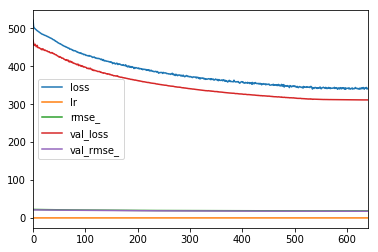

In [183]:
pd.DataFrame(history.history).plot();

### Modeling w/ SMOTE data

In [37]:
def create_model_2(learn_rate=0.001, decay=0.01 ,init='normal', drop_out=0.2, loss='mse'):
    model = Sequential()
    model.add(Dense(units=40, kernel_initializer=init, input_shape=(smote_x.shape[1],)))
    model.add(Activation(activation='relu'))
    model.add(Dropout(drop_out))
    model.add(Dense(units=20, kernel_initializer=init))
    model.add(Activation(activation='relu'))
    model.add(Dropout(drop_out))
    model.add(Dense(1, kernel_initializer='normal'))
    model.compile(loss=loss, 
              optimizer=Adam(lr=learn_rate, decay=decay), 
              metrics=[rmse_])
    return model

model2 = create_model_2()

In [38]:
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 40)                2040      
_________________________________________________________________
activation_7 (Activation)    (None, 40)                0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 40)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 20)                820       
_________________________________________________________________
activation_8 (Activation)    (None, 20)                0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 21        
Total para

In [39]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                  factor=0.2, 
                  patience=5,   
                  epsilon=0.0001,  
                  min_lr=0)
modelchecker = ModelCheckpoint('mlp_model_SMOTE.h5', save_best_only=True)

earlystopper = EarlyStopping(patience=12, mode='min')

In [41]:
batch_size = 500
epochs = 100
history = model2.fit(smote_x, smote_y,
                    validation_data=(dim_reduced_test_x[y_test>0], y_test[y_test>0]),
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    callbacks=[reduce_lr, earlystopper, modelchecker])

Train on 320028 samples, validate on 2280 samples
Epoch 1/100
320028/320028 [==============================] - 3s - loss: 322.8524 - rmse_: 17.8912 - val_loss: 604.9241 - val_rmse_: 24.5142
Epoch 2/100
320028/320028 [==============================] - 3s - loss: 323.0171 - rmse_: 17.8998 - val_loss: 604.7950 - val_rmse_: 24.5116
Epoch 3/100
320028/320028 [==============================] - 3s - loss: 322.8675 - rmse_: 17.8885 - val_loss: 604.5996 - val_rmse_: 24.5077
Epoch 4/100
320028/320028 [==============================] - 3s - loss: 322.8083 - rmse_: 17.8915 - val_loss: 604.5450 - val_rmse_: 24.5066
Epoch 5/100
320028/320028 [==============================] - 3s - loss: 322.8303 - rmse_: 17.8872 - val_loss: 604.4194 - val_rmse_: 24.5040
Epoch 6/100
320028/320028 [==============================] - 3s - loss: 322.8706 - rmse_: 17.8925 - val_loss: 604.4239 - val_rmse_: 24.5041
Epoch 7/100
320028/320028 [==============================] - 3s - loss: 322.7970 - rmse_: 17.8906 - val_loss: 

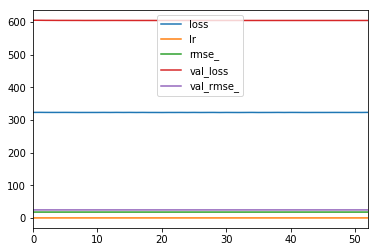

In [42]:
pd.DataFrame(history.history).plot();

In [70]:
model = load_model('mlp_model_OS.h5', custom_objects={'rmse_': rmse_})
model2 = load_model('mlp_model_SMOTE.h5', custom_objects={'rmse_': rmse_})

In [79]:
# lets test our models on the spenders in testing set
spender_test_index = y_test>0

pred_os = model.predict(norm_test_x[spender_test_index])
pred_smote = model2.predict(dim_reduced_test_x[spender_test_index])

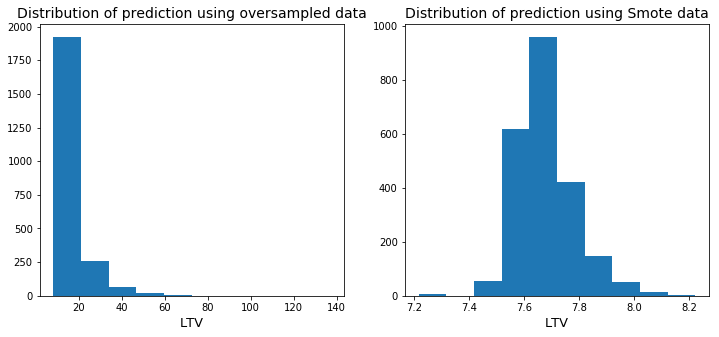

In [85]:
f, (ax1,ax2) = plt.subplots(1, 2, figsize=(12,5))

ax1.hist(pred_os)
ax1.set_title('Distribution of prediction using oversampled data', fontsize=14)
ax1.set_xlabel('LTV', fontsize=13)
ax2.hist(pred_smote)
ax2.set_title('Distribution of prediction using Smote data', fontsize=14)
ax2.set_xlabel('LTV', fontsize=13)
plt.show();

In [91]:
mean_ltv = y_test[spender_test_index].mean()


nrmse_os_all = rmse(y_test[spender_test_index].reshape((pred_os.shape)), pred_os)/mean_ltv
nrmse_smote_all = rmse(y_test[spender_test_index].reshape((pred_smote.shape)), pred_smote)/mean_ltv
print('nrmse for all spenders using mlp trained on oversampled data: ', '%.4f'%nrmse_os_all)
print('nrmse for all spenders using mlp trained on smote data: ', '%.4f'%nrmse_smote_all)

nrmse for all spenders using mlp trained on oversampled data:  1.4888
nrmse for all spenders using mlp trained on smote data:  1.5169


In [93]:
premium_index = np.where(np.logical_and(y_test>30, y_test<=70))[0]

pred_premium_os = model.predict(norm_test_x[premium_index])
pred_premium_smote = model2.predict(dim_reduced_test_x[premium_index])

nrmse_premium_os = rmse(y_test[premium_index].reshape((pred_premium_os.shape)), pred_premium_os)/mean_ltv
nrmse_premium_smote = rmse(y_test[premium_index].reshape((pred_premium_smote.shape)), pred_premium_smote)/mean_ltv
print('nrmse for the premium users using mlp trained on oversampled data: ', '%.4f'%nrmse_premium_os)
print('nrmse for the premium users using mlp trained on smote data: ', '%.4f'%nrmse_premium_smote)

nrmse for the premium users using mlp trained on oversampled data:  1.9919
nrmse for the premium users using mlp trained on smote data:  2.4049


In [92]:
pred_high_os = model.predict(norm_test_x[y_test>100])
pred_high_smote = model2.predict(dim_reduced_test_x[y_test>100])

nrmse_high_os = rmse(y_test[y_test>100].reshape((pred_high_os.shape)), pred_high_os)/mean_ltv
nrmse_high_smote = rmse(y_test[y_test>100].reshape((pred_high_smote.shape)), pred_high_smote)/mean_ltv
print('nrmse for the HIGH SPENDERS using mlp trained on oversampled data: ', '%.4f'%nrmse_high_os)
print('nrmse for the HIGH SPENDERS using mlp trained on smote data: ', '%.4f'%nrmse_high_smote)

nrmse for the HIGH SPENDERS using mlp trained on oversampled data:  5.8870
nrmse for the HIGH SPENDERS using mlp trained on smote data:  6.4495


## Hyperparameter Tuning

In [203]:
# tune_model = KerasRegressor(build_fn=create_model, 
#                             verbose=0,
#                             epochs=500, 
#                             learn_rate=0.01, 
#                             decay=0.01, 
#                             init='normal', 
#                             drop_out=0.2, 
#                             loss='mae', 
#                             units=32)

# batches = [300, 400]
# decay = [0.1, 0.001, 0.0001]

# param_grid = dict(
#                   decay=decay,
#                   batch_size=batches, 
#                   )
# param_grid

# grid = GridSearchCV(estimator=tune_model, param_grid=param_grid, cv=5, n_jobs=30, verbose=1)
# grid_result = grid.fit(res_x,res_y)

# print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# means = grid_result.cv_results_['mean_test_score']
# stds = grid_result.cv_results_['std_test_score']
# params = grid_result.cv_results_['params']
# for mean, stdev, param in zip(means, stds, params):
#     print("%f (%f) with: %r" % (mean, stdev, param))
